# Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles 
This is the code for the paper entitled "[**Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles**](https://arxiv.org/pdf/1910.08635.pdf)" published in IEEE GlobeCom 2019.  
Authors: Li Yang (liyanghart@gmail.com), Abdallah Moubayed, Ismail Hamieh, and Abdallah Shami  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

If you find this repository useful in your research, please cite:  
L. Yang, A. Moubayed, I. Hamieh and A. Shami, "Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles," 2019 IEEE Global Communications Conference (GLOBECOM), 2019, pp. 1-6, doi: 10.1109/GLOBECOM38437.2019.9013892.  

## Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [4]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017.csv')
# The results in this code is based on the original CICIDS2017 dataset. Please go to cell [10] if you work on the sampled dataset. 

FileNotFoundError: [Errno 2] No such file or directory: './data/CICIDS2017.csv'

In [ ]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,109,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,52,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,34,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,32215,4,2,112,152,28,28,28.0,0.00000,76,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,324,2,2,84,362,42,42,42.0,0.00000,181,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,82,2,1,31,6,31,0,15.5,21.92031,6,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,1048635,6,2,192,256,32,32,32.0,0.00000,128,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.Label.value_counts()

BENIGN          2273097
DoS              380699
PortScan         158930
BruteForce        13835
WebAttack          2180
Bot                1966
Infiltration         36
Name: Label, dtype: int64

### Data sampling
Due to the space limit of GitHub files, we sample a small-sized subset for model learning using random sampling

In [ ]:
# Randomly sample instances from majority classes
df_minor = df[(df['Label']=='WebAttack')|(df['Label']=='Bot')|(df['Label']=='Infiltration')]
df_BENIGN = df[(df['Label']=='BENIGN')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df_DoS = df[(df['Label']=='DoS')]
df_DoS = df_DoS.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_PortScan = df[(df['Label']=='PortScan')]
df_PortScan = df_PortScan.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_BruteForce = df[(df['Label']=='BruteForce')]
df_BruteForce = df_BruteForce.sample(n=None, frac=0.2, replace=False, weights=None, random_state=None, axis=0)

In [ ]:
df_s = df_BENIGN.append(df_DoS).append(df_PortScan).append(df_BruteForce).append(df_minor)

In [ ]:
df_s = df_s.sort_index()

In [ ]:
# Save the sampled dataset
df_s.to_csv('./data/CICIDS2017_sample.csv',index=0)

NameError: name 'df_s' is not defined

### Preprocessing (normalization and padding values)

In [6]:
df = pd.read_csv('./data/CICIDS2017_sample.csv')

In [7]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [9]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)
y_train=y_train.astype('int') #have to add this line for stuff to work
y_test=y_test.astype('int') #have to add this line for stuff to work

In [10]:
X_train.shape

(45328, 77)

In [11]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

### Oversampling by SMOTE

In [12]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

In [13]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [14]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.9958528192005647
Precision of DT: 0.9958540043022182
Recall of DT: 0.9958528192005647
F1-score of DT: 0.9958495540736004
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.71      0.71      0.71         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      1.00       436

    accuracy                           1.00     11333
   macro avg       0.95      0.95      0.95     11333
weighted avg       1.00      1.00      1.00     11333



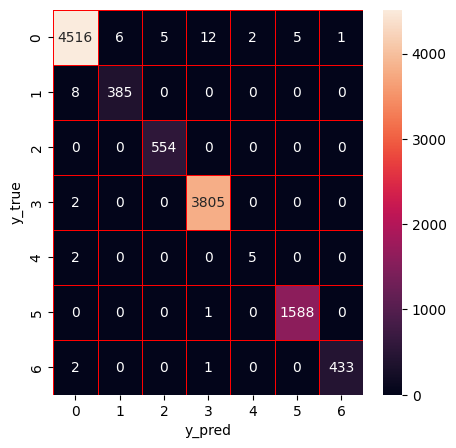

In [15]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [16]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9959410570899144
Precision of RF: 0.9959439594417301
Recall of RF: 0.9959410570899144
F1-score of RF: 0.9959162800592014
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4547
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.97      0.98       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



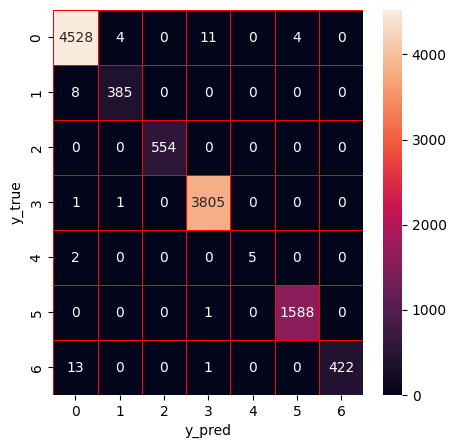

In [17]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [18]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9927644930733257
Precision of ET: 0.9927843581646408
Recall of ET: 0.9927644930733257
F1-score of ET: 0.9927507365881663
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.96      0.97      0.97       393
           2       0.99      1.00      0.99       554
           3       0.99      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.97      0.98       436

    accuracy                           0.99     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       0.99      0.99      0.99     11333



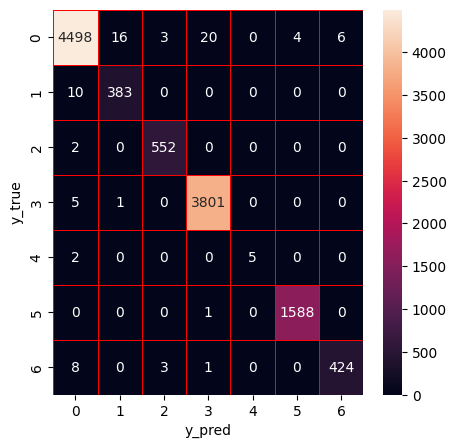

In [19]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [20]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.99435277508162
Precision of XGBoost: 0.9943418265940117
Recall of XGBoost: 0.99435277508162
F1-score of XGBoost: 0.9943347813276495
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



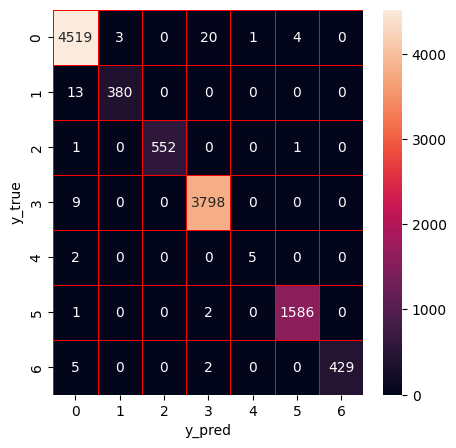

In [21]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [22]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [23]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [24]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [25]:
print(dt_train)

[[5]
 [3]
 [5]
 ...
 [4]
 [4]
 [4]]


In [26]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [27]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.9958528192005647
Precision of Stacking: 0.9958555670995775
Recall of Stacking: 0.9958528192005647
F1-score of Stacking: 0.9958352604251691
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.98      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      1.00       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



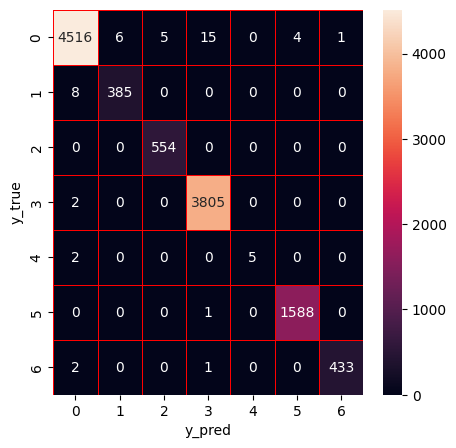

In [28]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Feature Selection

### Feature importance

In [29]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [30]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [31]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.1171, 'Bwd Packet Length Std'), (0.0891, 'Bwd Packet Length Min'), (0.0639, 'Average Packet Size'), (0.05, 'Init_Win_bytes_backward'), (0.0415, 'Init_Win_bytes_forward'), (0.0391, 'PSH Flag Count'), (0.0391, 'Bwd Packets/s'), (0.0336, 'Avg Bwd Segment Size'), (0.0315, 'Packet Length Std'), (0.0295, 'Bwd Packet Length Mean'), (0.0247, 'Fwd Header Length'), (0.0233, 'Packet Length Mean'), (0.0219, 'Bwd Header Length'), (0.0176, 'Total Length of Fwd Packets'), (0.0175, 'Bwd Packet Length Max'), (0.0169, 'Max Packet Length'), (0.0166, 'min_seg_size_forward'), (0.0162, 'act_data_pkt_fwd'), (0.0159, 'Subflow Bwd Packets'), (0.0152, 'ACK Flag Count'), (0.0137, 'Fwd IAT Max'), (0.0127, 'Fwd Header Length.1'), (0.0108, 'Fwd PSH Flags'), (0.0105, 'Total Length of Bwd Packets'), (0.0105, 'Min Packet Length'), (0.0104, 'Packet Length Variance'), (0.0099, 'Total Fwd Packets'), (0.0096, 'Fwd IAT Mean'), (0.009, 'Fwd IAT Min'), (0.0089, 'Total Backward Packets'), (

In [32]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [33]:
len(f_list)

77

In [34]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [35]:
X_fs = df[fs].values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)
y_train=y_train.astype('int') #have to add this line for stuff to work
y_test=y_test.astype('int') #have to add this line for stuff to work

In [37]:
X_train.shape

(45328, 40)

In [38]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
Name: count, dtype: int64

### Oversampling by SMOTE

In [39]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500})

In [40]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [41]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4     1500
Name: count, dtype: int64

## Machine learning model training after feature selection

Accuracy of DT: 0.995764581311215
Precision of DT: 0.9957636431362107
Recall of DT: 0.995764581311215
F1-score of DT: 0.9957466102695667
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       0.99      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



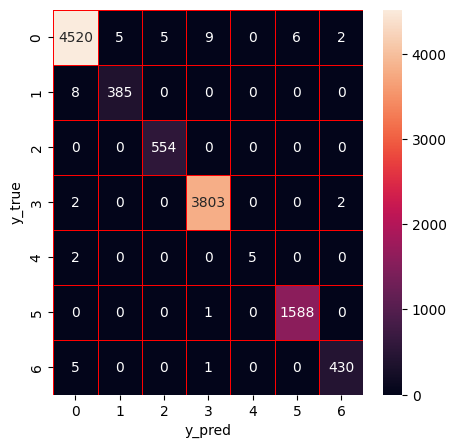

In [42]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [43]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.9965587223153622
Precision of RF: 0.9965584839599324
Recall of RF: 0.9965587223153622
F1-score of RF: 0.9965419707479967
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.98      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



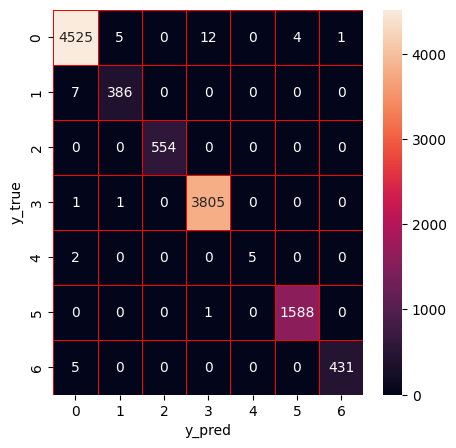

In [44]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [45]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 0.9948822024177182
Precision of ET: 0.9948792268681634
Recall of ET: 0.9948822024177182
F1-score of ET: 0.9948729828897367
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.97      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.99      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



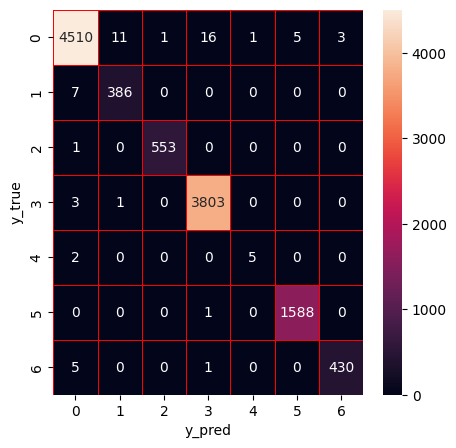

In [46]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [47]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.994088061413571
Precision of XGBoost: 0.9940823558704176
Recall of XGBoost: 0.994088061413571
F1-score of XGBoost: 0.9940686604836408
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       1.00      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.97      0.99       436

    accuracy                           0.99     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       0.99      0.99      0.99     11333



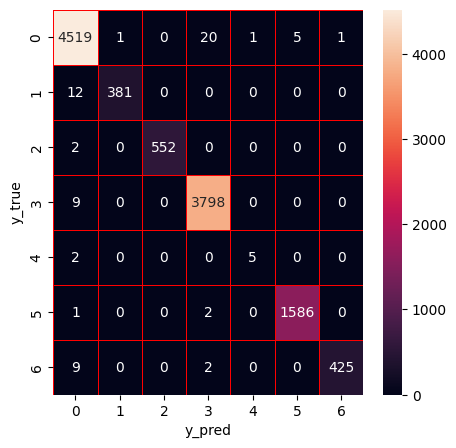

In [48]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [49]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [50]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [51]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [52]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.994088061413571
Precision of Stacking: 0.9941029687131706
Recall of Stacking: 0.994088061413571
F1-score of Stacking: 0.9940663282102209
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       0.99      1.00      0.99      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           0.99     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       0.99      0.99      0.99     11333



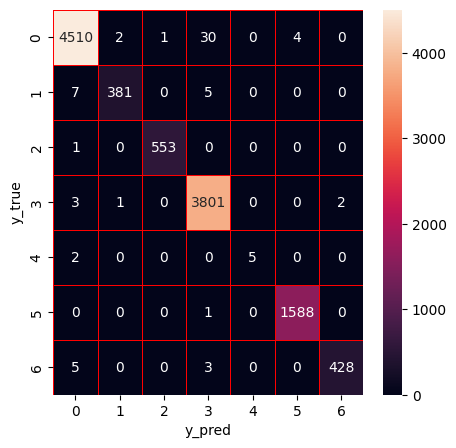

In [53]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()